**import** **libaraies**

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

from numpy import inf
from numpy import nan

In [ ]:
# Make sure that you have the dependency installed on your system
# If not installed, install by running the following
!pip install kafka-python

**Evaluation**

In [ ]:
def model_Evaluate(model,X_test):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    #Print the evaluation metrics for the dataset.
    f1=f1_score(y_test, y_pred, average='weighted')
    print("the weighted f1_score:",f1)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(model, X_test,y_test, values_format='d')
    plt.show()
    return f1

**clean the data**

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame)
    #drop nan
    df.dropna(inplace=True)
    #remove inf
    x = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[x].astype(np.float64)

**access drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**read the data**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/cicids_static_data.csv',skipinitialspace=True) 

In [ ]:
df['Label'].value_counts()

BENIGN    22744
ATTACK     2447
Name: Label, dtype: int64

**label encoder**

In [ ]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'Label'.
df['Label']= label_encoder.fit_transform(df['Label'])

In [ ]:
df=clean_dataset(df)

**split the data**

In [ ]:
X=df.drop(['Label'],axis=1)
y=df['Label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109)

In [ ]:
y_train.value_counts()

1.0    18171
0.0     1972
Name: Label, dtype: int64

**build the frist model** 

the weighted f1_score: 0.9937995660578486
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97       471
         1.0       0.99      1.00      1.00      4565

    accuracy                           0.99      5036
   macro avg       0.99      0.97      0.98      5036
weighted avg       0.99      0.99      0.99      5036



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


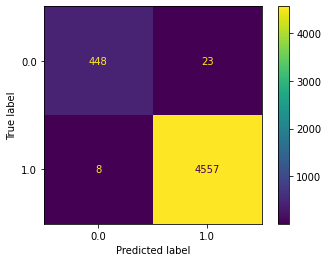

0.9937995660578486

In [ ]:

classifier_rf = RandomForestClassifier(random_state=109, n_jobs=-1, max_depth=15, n_estimators=10)
classifier_rf.fit(X_train, y_train)

y_predict = classifier_rf.predict(X_test)
model_Evaluate(classifier_rf,X_test)


the weighted f1_score: 0.9937995660578486
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97       471
         1.0       0.99      1.00      1.00      4565

    accuracy                           0.99      5036
   macro avg       0.99      0.97      0.98      5036
weighted avg       0.99      0.99      0.99      5036



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


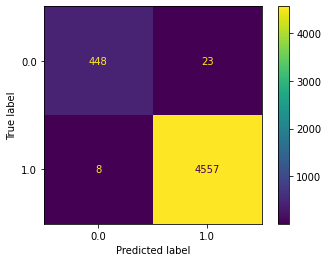

0.9937995660578486

In [ ]:
classifier_rf2 = RandomForestClassifier(random_state=109, n_jobs=-1, max_depth=15, n_estimators=10)
classifier_rf2.fit(X_train, y_train)

y_predict = classifier_rf2.predict(X_test)
model_Evaluate(classifier_rf,X_test)

**the second model**

the weighted f1_score: 0.9970171767141024
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       471
         1.0       1.00      1.00      1.00      4565

    accuracy                           1.00      5036
   macro avg       0.99      0.99      0.99      5036
weighted avg       1.00      1.00      1.00      5036



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


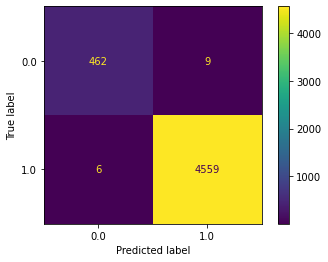

In [ ]:
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
f1=model_Evaluate(model,X_test)

**the best model is rf **

**Train the models on all the data**

In [ ]:
classifier_rf.fit(X, y)
classifier_rf2.fit(X, y)
model.fit(X, y)

XGBClassifier()

In [ ]:
y.value_counts()

1.0    22736
0.0     2443
Name: Label, dtype: int64

**Streaming**

In [ ]:
#make all preproccesing step on the packets
def clean_packets(packets):
  packets['Label']= label_encoder.transform(packets['Label'])
  packets=clean_dataset(packets)
  return packets


In [ ]:
import time
from kafka import KafkaConsumer
# call the static data
df_test=df

#list for f1_score 
f_dynamic=[]
f_xgb=[]
f_staticmodel=[]
#list for recall
recall_dynamic=[]
recall_staticmodel=[]
recall_xgb=[]
#list for percision
precision_dynamic=[]
precision_staticmodel=[]
precision_xgb=[]


# Import the python Consumer Client for Kafka
consumer = KafkaConsumer(
      'task1',  
      bootstrap_servers="34.130.121.39:9092",
      sasl_plain_username="student",
      sasl_plain_password="uottawa",
      security_protocol="SASL_PLAINTEXT",
      sasl_mechanism="PLAIN",
      auto_offset_reset='earliest',
      enable_auto_commit=False
  )

for j in range(0,100000,5000):
  
  packets=pd.DataFrame()

  # instantiate the KafkaConsumer Class using the arguments mentioned.
  # do not change any arguments other than the first positional argument.
  # Data Stream flowing in.
  i = j
  for message in consumer:
      data_packet = message.value
      x=eval(data_packet)
      packets=packets.append(x,ignore_index=True)

      if i == 4999+j:
          print("the number of packets is :  ",packets.shape[0])
          packets=clean_packets(packets)
          packets = packets.reindex(columns=df_test.columns)
          
          X_packets=packets.drop(['Label'],axis=1)
          y_packets=packets['Label']


          y_pred = classifier_rf.predict(X_packets)
          y_pred2 = classifier_rf2.predict(X_packets)
          y_predxgb = model.predict(X_packets)

          #Print the evaluation metrics for the dataset.
          f1_dynamic=f1_score(y_packets, y_pred, average='weighted')
          f1_static=f1_score(y_packets, y_pred2, average='weighted')
          f1_xgb=f1_score(y_packets, y_predxgb, average='weighted')

          recall_dynamic.append(recall_score(y_packets ,y_pred, average='weighted'))
          recall_staticmodel.append(recall_score(y_packets, y_pred2, average='weighted'))
          recall_xgb.append(recall_score(y_packets, y_predxgb, average='weighted'))
          
          precision_dynamic.append(precision_score(y_packets ,y_pred, average='weighted'))
          precision_staticmodel.append(precision_score(y_packets, y_pred2, average='weighted'))
          precision_xgb.append(precision_score(y_packets, y_predxgb, average='weighted'))

          print("the weighted f1_score for static  model:",f1_static)
          f_staticmodel.append(f1_static)
          print("trained on ")
          print(y.value_counts())

          print("the classification report for static model:")
          print(classification_report(y_packets, y_pred2))


          print("the weighted f1_score for pretraindmodel RF:",f1_dynamic)
          f_dynamic.append(f1_dynamic)
          print("the classification report for pretraind RF model:")
          print(classification_report(y_packets, y_pred))

          print("the weighted f1_score for pretraindmodel xgb:",f1_xgb)
          f_xgb.append(f1_xgb)
          print("the classification report for pretraind XGB model:")
          print(classification_report(y_packets, y_predxgb))
          print("static data size :",df_test.shape[0])
          #drop the first 5000 rows from te data
          df_test.drop(df_test.index[0:packets.shape[0]], inplace=True)
          #add the new packets
          df_test=df_test.append(packets ,ignore_index=True)
          print("static data after edit :",df_test.shape[0])
          Xnew=df_test.drop(['Label'],axis=1)
          ynew=df_test['Label']

          classifier_rf.fit(Xnew, ynew)
          print("pretrained done on ")
          print(ynew.value_counts())
          print("##############################################")


          ##############################################
          break
          
      i += 1 

the number of packets is :   5000
the weighted f1_score for static  model: 0.997388096026851
trained on 
1.0    22736
0.0     2443
Name: Label, dtype: int64
the classification report for pretraind static model:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       469
         1.0       1.00      1.00      1.00      4525

    accuracy                           1.00      4994
   macro avg       1.00      0.99      0.99      4994
weighted avg       1.00      1.00      1.00      4994

the weighted f1_score for pretraindmodel RF: 0.997388096026851
the classification report for pretraind RF model:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       469
         1.0       1.00      1.00      1.00      4525

    accuracy                           1.00      4994
   macro avg       1.00      0.99      0.99      4994
weighted avg       1.00      1.00      1.00      4994

the weighted f1_score 

In [ ]:
def compaire(dynamic,staticmodel,label):
  # line 1
  x1 = [i for i in range(len(dynamic))]
  y1 = dynamic
  # plotting the first model
  plt.plot(x1, y1, label = "pretrained")
  # line 2 
  x2 = x1
  y2 = staticmodel
  # plotting the second model 
  plt.plot(x2, y2, label = "static")
  plt.xlabel('number of packets')
  plt.ylabel(label)
  plt.title('fixed model vs pretrained model ')
  # show a legend on the plot
  plt.legend()
  # Display a figure.
  plt.show()

**XGB**

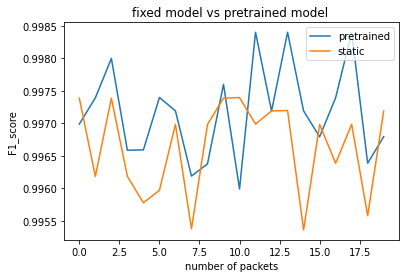

In [ ]:
compaire(f_xgb,f_staticmodel,"F1_score")

In [ ]:
winner=[]
for i in range(len(f_dynamic)):
  if f_xgb[i]>f_staticmodel[i]:
     winner.append("dynamic")
  else :   
     winner.append("static")

In [ ]:
final=pd.DataFrame({"static":f_staticmodel,"dynamic":f_xgb,"winner":winner})

In [ ]:
final['winner'].value_counts()

dynamic    14
static      6
Name: winner, dtype: int64

In [ ]:
np.mean(final['static'])

0.9966449668161594

In [ ]:
np.mean(final['dynamic'])

0.9971628691187755

**RF**

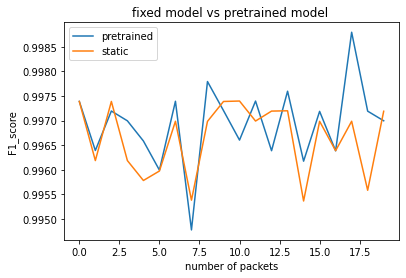

In [ ]:
compaire(f_dynamic,f_staticmodel,"F1_score")

In [ ]:
winner=[]
for i in range(len(f_dynamic)):
  if f_dynamic[i]>f_staticmodel[i]:
     winner.append("dynamic")
  else :   
     winner.append("static")

In [ ]:
final=pd.DataFrame({"static":f_staticmodel,"dynamic":f_dynamic,"winner":winner})

In [ ]:
final['winner'].value_counts()

dynamic    12
static      8
Name: winner, dtype: int64

In [ ]:
np.mean(final['static'])

0.9966449668161594

In [ ]:
np.mean(final['dynamic'])

0.9969203993604607

In [ ]:
def compairemodels(rf,xgb,label):
  # line 1 
  x1 = [i for i in range(len(rf))]
  y1 = rf
  # plotting the first model
  plt.plot(x1, y1, label = "rf")
  # line 2 
  x2 = x1
  y2 = xgb
  # plotting the second model
  plt.plot(x2, y2, label = "xgb")
  plt.xlabel('number of packets')
  plt.ylabel(label)
  plt.title('fixed model vs pretrained model ')
  # show a legend on the plot
  plt.legend()
  # Display a figure.
  plt.show()

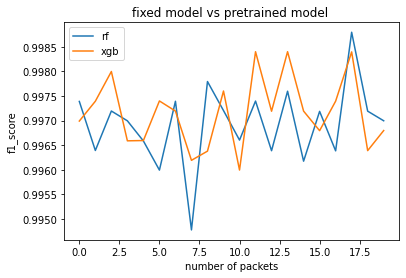

In [ ]:
compairemodels(f_dynamic,f_xgb,"f1_score")

In [ ]:
winner=[]
for i in range(len(f_dynamic)):
  if f_dynamic[i]>f_xgb[i]:
     winner.append("dynamic_rf")
  else :   
     winner.append("dynamic_xgb")

In [ ]:
final=pd.DataFrame({"f_xgb":f_xgb,"dynamic":f_dynamic,"winner":winner})

In [ ]:
final['winner'].value_counts()

dynamic_xgb    11
dynamic_rf      9
Name: winner, dtype: int64

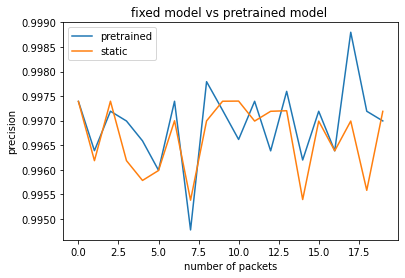

In [ ]:
compaire(precision_dynamic,precision_staticmodel,"precision")

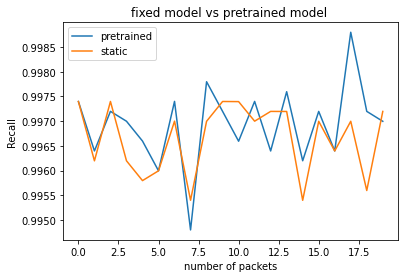

In [ ]:

compaire(recall_dynamic,recall_staticmodel,"Recall")

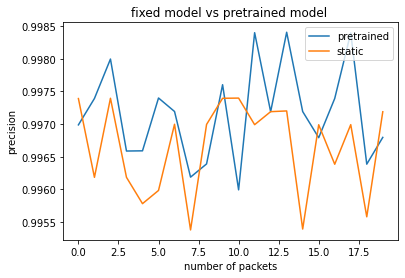

In [ ]:
compaire(precision_xgb,precision_staticmodel,"precision")

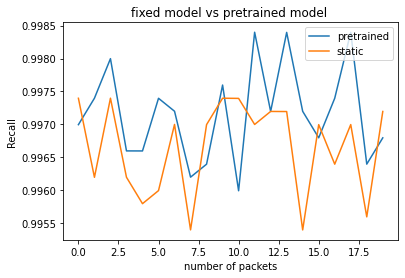

In [ ]:
compaire(recall_xgb,recall_staticmodel,"Recall")

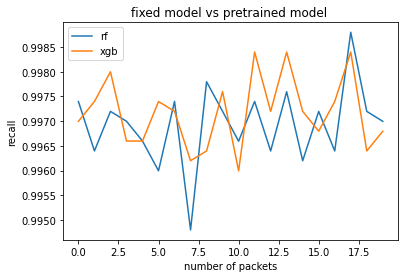

In [ ]:
compairemodels(recall_dynamic,recall_xgb,"recall")

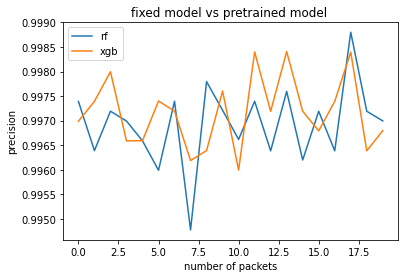

In [ ]:
compairemodels(precision_dynamic,precision_xgb,"precision")